In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

## Kernel profiling selection

In [30]:
kern = pd.read_csv("Kernel_analysis/prof_avg_duration.csv")
kern["exec_percentage"] = kern["Avg. Duration(ns)"] / np.sum(kern["Avg. Duration(ns)"]) * 100
kern.sort_values(by=["Avg. Duration(ns)"],ascending=False)

# Filter only main executing kernels
kern = kern[~kern['Name'].str.contains("void")] 

kern.head(5)[['Name',"exec_percentage"]]
print(kern.head(5)[['Name',"exec_percentage"]].to_csv())

# n
# print("Selected kernels:", kern.head(5)["Name"].to_list())


,Name,exec_percentage
0,dev_approximate_gravity,98.72371455308664
1,correct_particles,0.15385247665171645
3,cl_build_key_list,0.12446397018069301
4,compute_leaf,0.11253974307791499
6,predict_particles,0.0797434715929837



In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import json
import os


In [34]:

plot_title = "plummer_barnes_hut_n_vs_time_th0.2_1"
data_title = f"./Scaling/RTX3070/{plot_title}.json"
data_dict = json.loads(open(data_title).read())
n_pows = data_dict['n_pows']
token_arrays = data_dict['token_arrays']

In [36]:
use_keys = ["Sorting", "Data-reordering", "Tree-construction", "Grav:", "Build:", "TOTAL:"]
            #Sorting, Moving, Construction, Traverse
use_arrays =  {key: token_arrays[key] for key in use_keys}

[100, 1000, 10000, 100000, 1000000, 10000000]


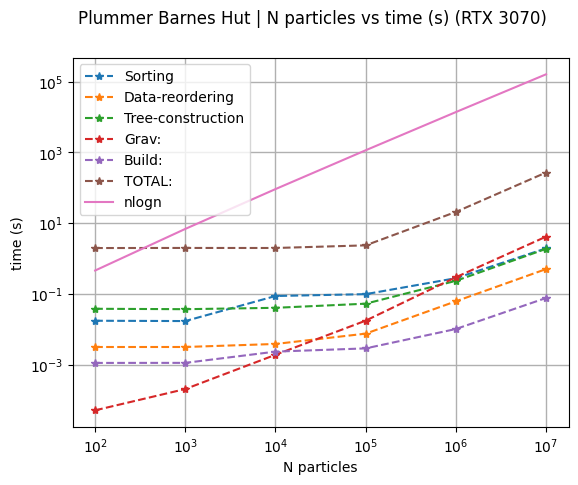

In [37]:
%matplotlib inline

x = []
for n in n_pows:
    x.append(10**n)
print(x)

fig, ax = plt.subplots()
fig.suptitle('Plummer Barnes Hut | N particles vs time (s) (RTX 3070)', fontsize=12)
ax.set_xlabel("N particles")
ax.set_ylabel("time (s)")

ax.grid(linestyle='-', linewidth=1)
ax.set_yscale('log')
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
ax.set_xscale('symlog')

for tokens in use_arrays:
    ax.plot(x, token_arrays[tokens],label=tokens, marker ='*',linestyle='dashed')

y = (x * np.log(x)) / 10**3
ax.plot(x, y,label="nlogn")

ax.legend(loc="upper left")
plt.show()


counter = 0
filename = plot_title + "_{}.png"
while os.path.isfile(filename.format(counter)):
    counter += 1
filename = plot_title + "_{}"
plot_title_final = filename.format(counter)

fig.savefig(plot_title_final +'.svg',format="svg",dpi=1200)
plt.close()

In [16]:
import json
thetas = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
times = []
times2 = []

for th in thetas:
    plot_title = f"plummer_barnes_hut_n_vs_time_th{th}_0"
    data_title = f"./Scaling/GTX1060/{plot_title}.json"
    data_dict = json.loads(open(data_title).rSead())
    n_pows = data_dict['n_pows']
    token_arrays = data_dict['token_arrays']
    # print(data_dict)
    times.append(token_arrays["TOTAL:"][-1])

print(times)

for th in thetas:
    plot_title = f"plummer_barnes_hut_n_vs_time_th{th}_1"
    data_title = f"./Scaling/RTX3070/{plot_title}.json"
    data_dict = json.loads(open(data_title).read())
    n_pows = data_dict['n_pows']
    token_arrays = data_dict['token_arrays']
    # print(data_dict)
    times2.append(token_arrays["TOTAL:"][-1])

print(times2)

[799.018, 317.317, 174.183, 120.092, 91.6917, 73.5027, 65.7697]
[270.784, 110.255, 60.5496, 43.0001, 33.6079, 27.3546, 24.7336]


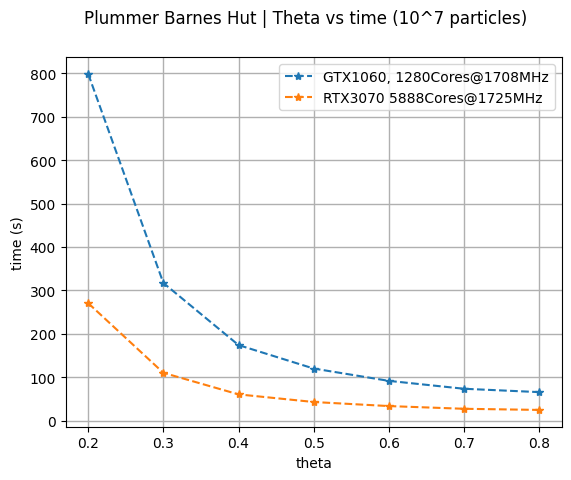

In [24]:
%matplotlib inline

x = thetas
# for n in n_pows:
#     x.append(10**n)
# print(x)

fig, ax = plt.subplots()
fig.suptitle('Plummer Barnes Hut | Theta vs time (10^7 particles)', fontsize=12)
ax.set_xlabel("theta")
ax.set_ylabel("time (s)")

ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale('log')
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
# ax.set_xscale('symlog')

ax.plot(x, times,label="GTX1060, 1280Cores@1708MHz", marker ='*',linestyle='dashed')
ax.plot(x, times2,label="RTX3070, 5888Cores@1725MHz", marker ='*',linestyle='dashed')

# for tokens in use_arrays:
#     ax.plot(x, token_arrays[tokens],label=tokens, marker ='*',linestyle='dashed')

# y = (x * np.log(x)) / 10**3
# ax.plot(x, y,label="nlogn")

ax.legend(loc="upper right")
plt.show()


counter = 0
filename = plot_title + "_{}.png"
while os.path.isfile(filename.format(counter)):
    counter += 1
filename = plot_title + "_{}"
plot_title_final = filename.format(counter)

fig.savefig(plot_title_final +'.svg',format="svg",dpi=1200)
plt.close()

# nvprof

In [214]:
# Command to run
# dev_approximate_gravity|correct_particles|cl_build_key_list|compute_leaf|predict_particles

csv_out = None
# header = ""
# units = ""
for kernel in ["dev_approximate_gravity","correct_particles","cl_build_key_list","compute_leaf","predict_particles"]:
    command = [
        "nvprof", "-f", "--print-gpu-trace", "--csv", "--kernels", f"::{kernel}:2", "--metrics", "all", "--events", "all",
        "../Bonsai-master/runtime/bonsai2_slowdust", 
        "--infile", "temp/plummer_gen_template_00000.0000-0", 
        "--snapiter", "0", 
        "--eps", "0.05", 
        "--theta", f"{_theta}"
        ,"-T", "100000000" 
        # ,"-I", f"{_I}" 
        ,"-I", "2" 
        ,"--dt", f"{_dt}" 
    ]

    # Initialize list to store differences between consecutive t_sim values
    t_sim_diff_list = []
    iter_list = []

    # Regular expressions to capture t_sim and iteration number
    t_sim_pattern = re.compile(r't_sim=\s+([\d.eE+-]+)\s+sec')
    iter_pattern = re.compile(r'iter=(\d+)')

    # Variables to store the previous t_sim and iter values
    prev_t_sim = None
    prev_iter = -1

    # Run the command and capture the output (both stdout and stderr)
    print(f"{i}: ", " ".join(command))
    output = subprocess.check_output(command, stderr=subprocess.STDOUT, text=True)

    # Clean up control characters like carriage return
    # This will ensure that only the latest instance of any overwritten lines is kept
    clean_output = output.replace('\r', '\n')

    # Process the cleaned output line by line
    start_read = False
    # header = None
    # units = None
    exec = []
    for line in clean_output.splitlines():
        clear_output(wait=True)
        display(str(line))
        # print(line)

        if "Profiling result" in line:
            start_read = True
            continue

        if not start_read:
            continue

        exec.append(line)
    if not csv_out:
        csv_out = exec[0] + "\n" + exec[1] + "\n"
    
    csv_out += exec[-1] + "\n"

print(csv_out)

file_name = "test.csv"
with open(file_name, 'w') as x_file:
    x_file.write(csv_out)

'"NVIDIA GeForce GTX 1060 6GB (0)","1","13","predict_particles",354,137544,137456,137456,137544,87590,87635,47032,47099,47033,47098,87597,87628,87496,87504,50000,50000,0,0,0,0,87577,87613,50010,50019,0,0,5,0,1098700,0,0,100000,0,300000,0,0,0,0,200000,0,0,0,0,0,0,0,0,3132,3986414,141989,9375,159459,5102688,5002688,1032854,53741408,12500,6250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6257,0,0,0,0,1036431,55246124,1074180,50.912835,100.000000,100.000000,98.040249,0.008027,0.000000,0.000000,0.000000,0.000000,52.000160,16.000000,0,0,0,0,650002,100000,0,5,175190,100029,0.000000,0.000000,87.452866,53.817149,94.180010,53.817149,0.000000,0.000000,0.000000,0.000000,87.452866,94.180010,53.817149,94.282263,53.832756,0.000000,2.755438,0.000000,0.000000,0.000000,0.000000,92.857143,100.000000,162500,0,0,0,0,1900000,700000,300000,600000,0,160739,"Low (1)",0.708706,0.701769,69.836709,4.036977,0.000000,0.893584,0.687806,0.026802,0.000000,1600000,0,2201568,0,100224,600000,500896,0,151364,6257,6257,159396,28146,0,0.000

"Device","Context","Stream","Kernel","Correlation_ID","tex0_cache_sector_queries","tex1_cache_sector_queries","tex0_cache_sector_misses","tex1_cache_sector_misses","fb_subp0_read_sectors","fb_subp1_read_sectors","fb_subp0_write_sectors","fb_subp1_write_sectors","l2_subp0_write_sector_misses","l2_subp1_write_sector_misses","l2_subp0_read_sector_misses","l2_subp1_read_sector_misses","l2_subp0_read_tex_sector_queries","l2_subp1_read_tex_sector_queries","l2_subp0_write_tex_sector_queries","l2_subp1_write_tex_sector_queries","l2_subp0_read_tex_hit_sectors","l2_subp1_read_tex_hit_sectors","l2_subp0_write_tex_hit_sectors","l2_subp1_write_tex_hit_sectors","l2_subp0_total_read_sector_queries","l2_subp1_total_read_sector_queries","l2_subp0_total_write_sector_queries","l2_subp1_total_write_sector_queries","l2_subp0_read_sysmem_sector_queries","l2_subp1_read_sysmem_sector_queries","l2_subp0_write_sysmem_sector_queries","l2_subp1_write_sysmem_sector_queries","elapsed_cycles_sm","gld_inst_8bit","gld

In [135]:
true_t_avg * 16

159.73199146666667

In [130]:
true_t_avg

0.0054826374

0.9611544834108405

In [17]:
true_t_avg * 16

NameError: name 'true_t_avg' is not defined

## Proof constant ....

In [179]:
import subprocess
import re
from IPython.display import clear_output, display
import resource

# Set stack size to unlimited (if necessary)
resource.setrlimit(resource.RLIMIT_STACK, (resource.RLIM_INFINITY, resource.RLIM_INFINITY))

# Command to run
command = [
    "../Bonsai-master/runtime/bonsai2_slowdust", 
    "--infile", "templates/plummer_fixed_template_100000_00000.0000-0", 
    "--snapname", "data/plummer_snap_mpi", 
    "--snapiter", "0", 
    "--eps", "0.05", 
    "--theta", "0.2"
    ,"-T", "10000000" 
    ,"-I", "96000" 
]

# Initialize list to store differences between consecutive t_sim values
t_sim_diff_list = []
iter_list = []

# Regular expressions to capture t_sim and iteration number
t_sim_pattern = re.compile(r't_sim=\s+([\d.eE+-]+)\s+sec')
iter_pattern = re.compile(r'iter=(\d+)')

# Variables to store the previous t_sim and iter values
prev_t_sim = None
prev_iter = -1

# Run the command and capture the output (both stdout and stderr)
output = subprocess.check_output(command, stderr=subprocess.PIPE, text=True)

# Clean up control characters like carriage return
# This will ensure that only the latest instance of any overwritten lines is kept
clean_output = output.replace('\r', '\n')

# Process the cleaned output line by line
for line in clean_output.splitlines():
    clear_output(wait=True)
    display(str(line))
    # print(line)

    # Extract iter value
    iter_match = iter_pattern.search(line)
    if iter_match:
        iter = int(iter_match.group(1))
        if iter - prev_iter != 1:
            continue
        iter_list.append(iter)
        prev_iter = iter

    # Extract t_sim value
    t_sim_match = t_sim_pattern.search(line)
    if t_sim_match:
        current_t_sim = float(t_sim_match.group(1))
        
        # If there's a previous t_sim, calculate the difference
        if prev_t_sim is not None:
            t_sim_diff_list.append(current_t_sim - prev_t_sim)
        
        # Update previous t_sim value
        prev_t_sim = current_t_sim

# Calculate and display statistics if list is not empty
if t_sim_diff_list:
    t_sim_diff_min = min(t_sim_diff_list)
    t_sim_diff_max = max(t_sim_diff_list)
    t_sim_diff_avg = sum(t_sim_diff_list) / len(t_sim_diff_list)

    print(f"Min t_sim difference: {t_sim_diff_min} sec")
    print(f"Max t_sim difference: {t_sim_diff_max} sec")
    print(f"Average t_sim difference: {t_sim_diff_avg} sec")
else:
    print("No t_sim differences found.")

# Output the final t_sim and iter values
print(f"Last t_sim: {prev_t_sim} sec")
print(f"Last iter: {prev_iter}")
print(t_sim_diff_list)


'iter=96000 : time= 6000  Etot= -0.2447949518  Ekin= 0.236529   Epot= -0.481324 : de= -0.00302302 ( 0.00302302 ) d(de)= -1.1454e-06 ( 9.59911e-06 ) t_sim=  4145.51 sec'

Min t_sim difference: 0.02999999999974534 sec
Max t_sim difference: 0.09999999999990905 sec
Average t_sim difference: 0.04318239582339923 sec
Last t_sim: 4145.51 sec
Last iter: 96000
[0.043250046326, 0.04314900000000001, 0.04333100000000001, 0.043102999999999975, 0.04369500000000001, 0.04114999999999999, 0.04325899999999999, 0.040071999999999997, 0.04327900000000001, 0.04335800000000001, 0.049599000000000004, 0.041573999999999944, 0.0422030000000001, 0.041574, 0.04556199999999999, 0.044365999999999906, 0.042101000000000055, 0.043744000000000005, 0.04189299999999996, 0.04334500000000008, 0.042205999999999966, 0.04200700000000002, 0.041605, 0.0433039999999999, 0.04255000000000009, 0.04200999999999988, 0.04516000000000009, 0.04058000000000006, 0.04184999999999994, 0.041099999999999914, 0.041890000000000205, 0.04161999999999999, 0.042629999999999946, 0.04326999999999992, 0.04635000000000011, 0.041609999999999925, 0.042280000000000095, 0.04214999999999991, 0.04123999999999994, 0.04183000000

Average t_sim difference: 0.003505322916666667 sec
Last t_sim: 336.511 sec
Last iter: 96000

Average t_sim difference: 0.0039460625 sec
Last t_sim: 37.8822 sec
Last iter: 9600

In [82]:
0.003505322916666667*9600

33.65110000000001

In [87]:
t_sim_diff_avg

0.003905906150658958

In [ ]:
0.003905906150658958

In [90]:
t_sim_diff_avg* prev_iter

38.397699046326004

In [71]:
(0.003929135416666667 * 96)

0.377197

In [91]:
(0.003929135416666667 * 96) / 0.427837

0.8816371655560412

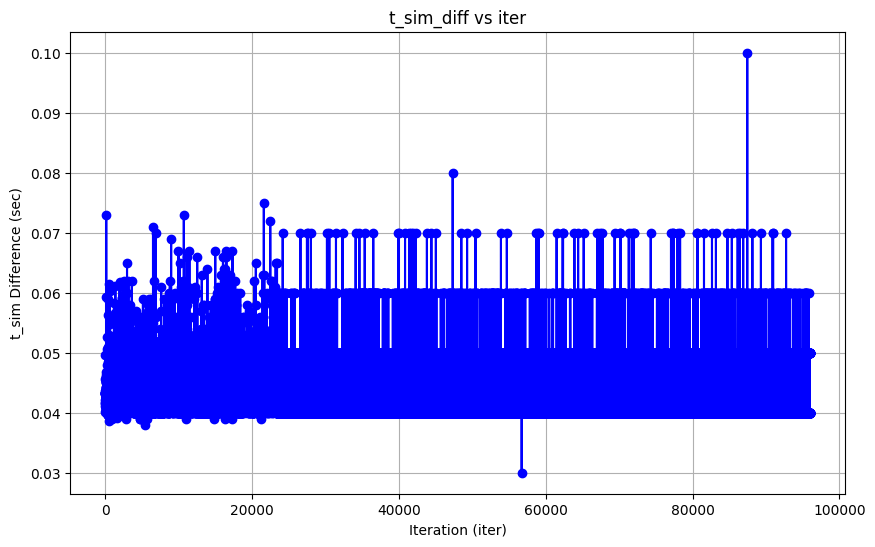

In [180]:
import matplotlib.pyplot as plt

# Plot the graph of t_sim_diff vs iter
if t_sim_diff_list and iter_list:
    # Remove the first iter as there is no corresponding t_sim_diff
    iter_list = iter_list[1:]

    plt.figure(figsize=(10, 6))
    plt.plot(iter_list, t_sim_diff_list, marker='o', linestyle='-', color='b')
    plt.title('t_sim_diff vs iter')
    plt.xlabel('Iteration (iter)')
    plt.ylabel('t_sim Difference (sec)')
    plt.grid(True)
    plt.show()

In [181]:
0.0431823 * 96000

4145.5008

In [517]:
import subprocess
import re
from IPython.display import clear_output, display
import resource

# Set stack size to unlimited (if necessary)
resource.setrlimit(resource.RLIMIT_STACK, (resource.RLIM_INFINITY, resource.RLIM_INFINITY))

# Command to run
command = [
    "../Bonsai-master/runtime/bonsai2_slowdust", 
    "--infile", "templates/plummer_fixed_template_10000000_00000.0000-0", 
    "--snapname", "data/plummer_snap_mpi", 
    "--snapiter", "0", 
    "--eps", "0.001", 
    "--theta", "0.2"
    ,"-T", "10000000" 
    ,"-I", "10" 
]

# Initialize list to store differences between consecutive t_sim values

iter_list = []
de_list = []
dde_list = []

# Regular expressions to capture t_sim and iteration number
t_sim_pattern = re.compile(r't_sim=\s+([\d.eE+-]+)\s+sec')
iter_pattern = re.compile(r'iter=(\d+)')
Etot_pattern = re.compile(r'Etot=\s+([\d.eE+-]+)')
Ekin_pattern = re.compile(r'Ekin=\s+([\d.eE+-]+)')
Epot_pattern = re.compile(r'Epot=\s+([\d.eE+-]+)')
de_pattern = re.compile(r'de=\s+([\d.eE+-]+)')
de_max_pattern = re.compile(r'\(\s+([\d.eE+-]+)\s+\)')
dde_pattern = re.compile(r'd\(de\)=\s+([\d.eE+-]+)')
dde_max_pattern = re.compile(r'\(\s+([\d.eE+-]+)\s+\)')


# Variables to store the previous t_sim and iter values
prev_t_sim = None
prev_iter = -1

# Run the command and capture the output (both stdout and stderr)
output = subprocess.check_output(command, stderr=subprocess.PIPE, text=True)

# Clean up control characters like carriage return
# This will ensure that only the latest instance of any overwritten lines is kept
clean_output = output.replace('\r', '\n')

# Process the cleaned output line by line
for line in clean_output.splitlines():
    # clear_output(wait=True)
    # display(str(line))
    # print(line)

    # Extract iter value
    iter_match = iter_pattern.search(line)
    if iter_match:
        iter = int(iter_match.group(1))
        if iter - prev_iter != 1:
            continue
        iter_list.append(iter)
        prev_iter = iter
        
    # Apply the regex patterns to extract the values
    t_sim_match = t_sim_pattern.search(line)
    if t_sim_match:
        # print(line)

        t_sim = t_sim_pattern.search(line)
        iteration = iter_pattern.search(line)
        Etot = Etot_pattern.search(line)
        Ekin = Ekin_pattern.search(line)
        Epot = Epot_pattern.search(line)
        de = de_pattern.search(line)
        de_max = de_max_pattern.findall(line)[0]  # First occurrence for de_max
        dde = dde_pattern.search(line)
        dde_max = dde_max_pattern.findall(line)[1]  # Second occurrence for dde_max

        # Extracted values
        extracted_values = {
            "t_sim": t_sim.group(1) if t_sim else None,
            "iter": iteration.group(1) if iteration else None,
            "Etot": Etot.group(1) if Etot else None,
            "Ekin": Ekin.group(1) if Ekin else None,
            "Epot": Epot.group(1) if Epot else None,
            "de": de.group(1) if de else None,
            "de_max": de_max if de_max else None,
            "dde": dde.group(1) if dde else None,
            "dde_max": dde_max if dde_max else None
        }
        de_list.append(float(extracted_values["de"]))
        dde_list.append(float(extracted_values["dde"]))



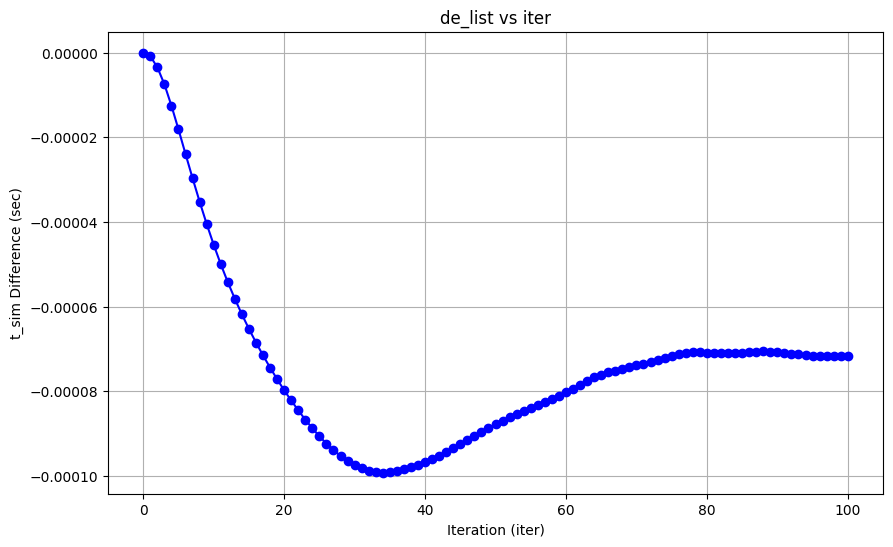

In [514]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the graph of t_sim_diff vs iter
if de_list and iter_list:
    # Remove the first iter as there is no corresponding t_sim_diff
    # iter_list = iter_list[1:]

    plt.figure(figsize=(10, 6))
    plt.plot(iter_list, de_list, marker='o', linestyle='-', color='b')
    plt.title('de_list vs iter')
    plt.xlabel('Iteration (iter)')
    plt.ylabel('t_sim Difference (sec)')
    plt.grid(True)

    plt.show()

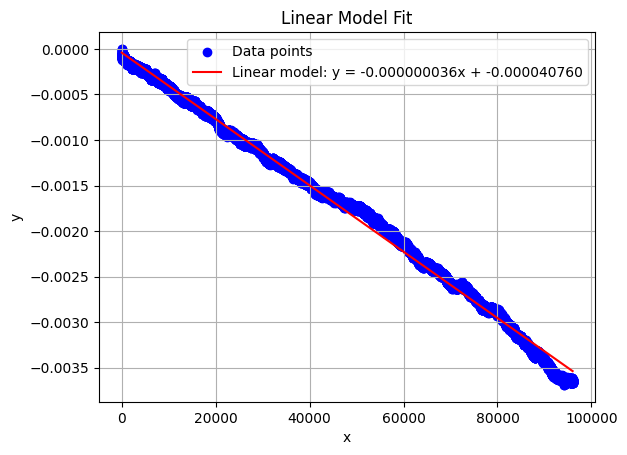

In [510]:

from sklearn.linear_model import LinearRegression
x = np.array(iter_list[:96000]).reshape(-1, 1)  # x values (reshaped to 2D for sklearn)
y = np.array(de_list[:96000])  # y values
model = LinearRegression()
model.fit(x, y)

# Get the slope (m) and intercept (b) of the model
m = model.coef_[0]
b = model.intercept_

# Predict y values for the given x values
y_pred = model.predict(x)

# Plot the data points and the linear model
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label=f'Linear model: y = {m:.9f}x + {b:.9f}')

# Add labels, title, and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Model Fit')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

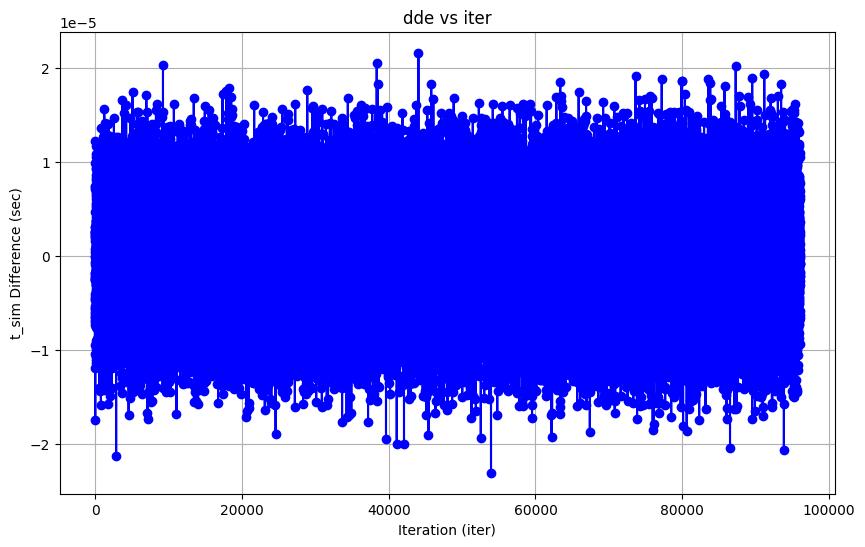

In [378]:
# Plot the graph of t_sim_diff vs iter
if dde_list and iter_list:
    # Remove the first iter as there is no corresponding t_sim_diff
    # iter_list = iter_list[1:]

    plt.figure(figsize=(10, 6))
    plt.plot(iter_list, dde_list, marker='o', linestyle='-', color='b')
    plt.title('dde vs iter')
    plt.xlabel('Iteration (iter)')
    plt.ylabel('t_sim Difference (sec)')
    plt.grid(True)
    plt.show()

In [473]:
dde_abs_list = dde_list[1:]
# print(dde_abs_list)
# [abs(x) for x in dde_list]

if dde_abs_list:

    dde_abs_list_min = min(dde_abs_list)
    dde_abs_list_max = max(dde_abs_list)
    dde_abs_list_avg = sum(dde_abs_list) / len(dde_abs_list)

    print(f"Min t_sim difference: {dde_abs_list_min} sec")
    print(f"Max t_sim difference: {dde_abs_list_max} sec")
    print(f"Average t_sim difference: {dde_abs_list_avg} sec")
else:
    print("No t_sim differences found.")

Min t_sim difference: -2.30982e-05 sec
Max t_sim difference: 2.15808e-05 sec
Average t_sim difference: -3.7953814897873166e-08 sec


In [453]:
vg = (de_list[-1] - de_list[1]) / 96000 

In [462]:
(de_list[960] - de_list[1]) / 960

-1.240746875e-07

In [461]:
vg * 960

-3.6325677e-05

In [428]:
de_list[1000]

-0.000152642

In [443]:
dde_abs_list_avg

-3.795341954975285e-08

In [433]:
de_list[96000] / (96000 * dde_abs_list_avg)

0.9985156484688904

## get from sqlite3

In [190]:
import sqlite3

# Path to your SQLite database file
db_path = 'prof2.nvvp'

# Connect to the database
connection = sqlite3.connect(db_path)

# This allows access to columns by name
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

# Example query
query = "SELECT * FROM CUPTI_ACTIVITY_KIND_DEVICE;"

# Execute the query
cursor.execute(query)

# Fetch the results
rows = cursor.fetchall()

# Convert rows to a list of dictionaries (with column names as keys)
results = [dict(row) for row in rows]
print(results)

# Close the connection
cursor.close()
connection.close()


[{'_id_': 1, 'flags': 1, 'globalMemoryBandwidth': 192192000, 'globalMemorySize': 6360072192, 'constantMemorySize': 65536, 'l2CacheSize': 1572864, 'numThreadsPerWarp': 32, 'coreClockRate': 1771500, 'numMemcpyEngines': 2, 'numMultiprocessors': 10, 'maxIPC': 6, 'maxWarpsPerMultiprocessor': 64, 'maxBlocksPerMultiprocessor': 32, 'maxSharedMemoryPerMultiprocessor': 98304, 'maxRegistersPerMultiprocessor': 65536, 'maxRegistersPerBlock': 65536, 'maxSharedMemoryPerBlock': 49152, 'maxThreadsPerBlock': 1024, 'maxBlockDimX': 1024, 'maxBlockDimY': 1024, 'maxBlockDimZ': 64, 'maxGridDimX': 2147483647, 'maxGridDimY': 65535, 'maxGridDimZ': 65535, 'computeCapabilityMajor': 6, 'computeCapabilityMinor': 1, 'id': 0, 'eccEnabled': 0, 'uuid': b'\x02$\xa5H\xe8\x03\xf9\xe6n\xda\x95\xab\xb7>X%', 'name': 2, 'isCudaVisible': 1}]
